# Functions for constructing structures

* 4 functions for constructing structures
* 2 CPU intensive: f1 and f2
* 1 disk IO intensive: f3
* 1 network IO intenstive: f4

In [1]:
import os
import logging
from io import BytesIO
import time
import zipfile
import numpy as np
import boto3
from datetime import datetime, timezone
from time import gmtime, strftime
import json
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
import pickle

In [3]:
import matplotlib.pyplot as plt

In [4]:
client = boto3.client('lambda')

In [5]:
function_prefix='Structures'

In [6]:
function_count = 4
function_number = 4

In [7]:
# The difference between UTC and local timezone
timezone_offset = 0

## Create Functions for Constructing 4 Apps

### Function Name List

In [8]:
function_name_list = [function_prefix+'_f'+str(i) for i in range(1, function_count+1)]
print(function_name_list)

['Structures_f1', 'Structures_f2', 'Structures_f3', 'Structures_f4']


### Send Requests to Create Lambda Functions

In [9]:
function_creation_response = []
for function in function_name_list:
    response = client.create_function(
        FunctionName=function,
        Runtime='python3.7',
        Role='arn:aws:iam::499537426559:role/ServerlessAppPerfOpt',
        Handler='lambda_function.lambda_handler',
        Code={
            'ZipFile': b"PK\x03\x04\x14\x00\x00\x00\x00\x00\xf3s;P\x84\xf0r\x96Z\x00\x00\x00Z\x00\x00\x00\x12\x00\x00\x00lambda_function.pydef lambda_handler(event, context):\n    pass\n    return {\n        'statusCode': 200\n    }\nPK\x03\x04\x14\x00\x00\x00\x00\x00\x05q;P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x00\x00.ipynb_checkpoints/PK\x01\x02\x14\x03\x14\x00\x00\x00\x00\x00\xf3s;P\x84\xf0r\x96Z\x00\x00\x00Z\x00\x00\x00\x12\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xb4\x81\x00\x00\x00\x00lambda_function.pyPK\x01\x02\x14\x03\x14\x00\x00\x00\x00\x00\x05q;P\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x13\x00\x00\x00\x00\x00\x00\x00\x00\x00\x10\x00\xfdA\x8a\x00\x00\x00.ipynb_checkpoints/PK\x05\x06\x00\x00\x00\x00\x02\x00\x02\x00\x81\x00\x00\x00\xbb\x00\x00\x00\x00\x00"
        },
        Description='Analytical Model Evaluation {}'.format(function),
        Timeout=60,
        MemorySize=128
    )
    function_creation_response.append(response)
    time.sleep(0.1)
print([item['StateReasonCode'] for item in function_creation_response])

['Creating', 'Creating', 'Creating', 'Creating']


## Update all Functions

### Update Function Code

In [10]:
functions=[]
for file in os.listdir('functions'):
    path=os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/'+file))
    if not file.startswith('.') and os.path.isdir(path):
        functions.append(file)
for function_folder in functions:
    buf = BytesIO()
    with zipfile.ZipFile(buf, 'w') as z:
        for file in os.listdir('functions/'+function_folder):
            z.write(os.path.abspath(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))), os.path.basename(os.path.join(os.path.dirname('__file__'), 'functions/{}/{}'.format(function_folder,file))))
    buf.seek(0)
    pkg = buf.read()
    client.update_function_code(FunctionName='{}_{}'.format(function_prefix, function_folder),ZipFile=pkg)

### Update Function Memory Configuration

In [11]:
mem_config_list={
    'f1':1280,
    'f2':896,
    'f3':1536,
    'f4':1088
}

In [12]:
for function in mem_config_list.keys():
    client.update_function_configuration(FunctionName='{}_{}'.format(function_prefix, function), MemorySize=mem_config_list[function])

# Profile Functions

## Test Run

In [13]:
client.invoke(FunctionName='{}_{}'.format(function_prefix, 'f1'), InvocationType='Event')

{'ResponseMetadata': {'RequestId': '858fd250-880f-4141-8e16-f8ad0955b0e5',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Thu, 23 Dec 2021 03:01:31 GMT',
   'content-length': '0',
   'connection': 'keep-alive',
   'x-amzn-requestid': '858fd250-880f-4141-8e16-f8ad0955b0e5',
   'x-amzn-remapped-content-length': '0',
   'x-amzn-trace-id': 'root=1-61c3e68b-5321b9a97a99d21105a28e87;sampled=0'},
  'RetryAttempts': 0},
 'StatusCode': 202,
 'Payload': <botocore.response.StreamingBody at 0x7f1c85c1da60>}

In [14]:
logging.basicConfig(filename='invoke.log', encoding='utf-8', format='%(asctime)s.%(msecs)03d %(message)s', datefmt='%Y-%m-%d %H:%M:%S', level=logging.INFO)

## Run

In [15]:
for i in range(10000):
    time.sleep(2.4)
    for name in function_name_list:
        response = client.invoke(FunctionName=name, InvocationType='Event')
        RequestId = response.get('ResponseMetadata', {}).get('RequestId')
        StatusCode = response.get('StatusCode', 'ERR')
        logging.info(f'{i+1} {StatusCode} {name} {RequestId}')
        time.sleep(0.1)

## Get the start time and the end time

In [16]:
profile_function_start_time = ' '.join(os.popen('head -1 invoke.log').read().split(' ')[:2])
profile_function_end_time = ' '.join(os.popen('tail -1 invoke.log').read().split(' ')[:2])
profile_function_start_time = datetime.strptime(profile_function_start_time, '%Y-%m-%d %H:%M:%S.%f')
profile_function_end_time = datetime.strptime(profile_function_end_time, '%Y-%m-%d %H:%M:%S.%f')

In [17]:
profile_function_start_time

datetime.datetime(2021, 12, 23, 3, 6, 25, 361000)

In [18]:
profile_function_end_time

datetime.datetime(2021, 12, 23, 14, 26, 52, 902000)

In [19]:
profile_function_start_time = int(datetime.timestamp(profile_function_start_time)) - 60

In [20]:
profile_function_end_time = int(datetime.timestamp(profile_function_end_time)) + 60

# CloudWatch Logs

In [21]:
logclient = boto3.client('logs')

## Query AppMdl Lambda Function Logs

### Functions for parsing Logs

In [22]:
def lambda_report_log_to_dict(log):
    res={}
    lis=[item.split(': ') for item in log[1]['value'].split('\t')]
    res['RequestId']=lis[0][1]
    res['Duration']=float(lis[1][1].split(' ')[0])
    res['Billed_Duration']=int(lis[2][1].split(' ')[0])
    res['Memory_Size']=int(lis[3][1].split(' ')[0])
    res['Max_Memory_Used']=int(lis[4][1].split(' ')[0])
    res['UTC_Timestamp'] = time.mktime(datetime.strptime(log[0]['value'], "%Y-%m-%d %H:%M:%S.%f").timetuple()) +timezone_offset*3600
    return res

### Prepare Logs

In [23]:
query_lambda = []
for function in function_name_list:
    query_lambda.append(logclient.start_query(
        logGroupName='/aws/lambda/{}'.format(function),
        queryString="fields @timestamp, @message| filter @message like 'REPORT'| sort @timestamp asc",
        startTime=profile_function_start_time,
        endTime=profile_function_end_time,
        limit=10000
        ))
    time.sleep(4)
time.sleep(10)

### Retrieve Logs

In [24]:
query_lambda_results = []
for q in query_lambda:
    query_lambda_results.append(logclient.get_query_results(
        queryId=q['queryId']
    ))
    time.sleep(4)

In [25]:
with open('query_lambda_results.pickle', 'wb') as f:
    f.write(pickle.dumps(query_lambda_results))

In [26]:
AppMdl_lambda_logs_dict = {'f'+str(i):None for i in range(1, function_count+1)}
for i in range(1, function_count+1):
    AppMdl_lambda_logs_dict['f'+str(i)] = [lambda_report_log_to_dict(item) for item in query_lambda_results[i-1]['results']]
    for item in AppMdl_lambda_logs_dict['f'+str(i)]:
        item['Function']='f'+str(i)

In [27]:
len(AppMdl_lambda_logs_dict['f1'])

10000

#### Convert Logs into DataFrame and Save as CSV

In [28]:
AppMdl_lambda_logs=pd.DataFrame()
for i in range(1, function_count+1):
    AppMdl_lambda_logs = AppMdl_lambda_logs.append(pd.DataFrame(AppMdl_lambda_logs_dict['f'+str(i)]))
AppMdl_lambda_logs.index=range(AppMdl_lambda_logs.shape[0])
AppMdl_lambda_logs=AppMdl_lambda_logs[['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'UTC_Timestamp', 'RequestId']]
AppMdl_lambda_logs.to_csv('Structures_lambda_logs.csv',index=False)

In [29]:
AppMdl_lambda_logs = pd.read_csv('Structures_lambda_logs.csv', low_memory=False)
AppMdl_lambda_logs.columns = ['Function', 'Memory_Size', 'Max_Memory_Used', 'Duration', 'Billed_Duration', 'UTCTimestamp', 'RequestId']

In [30]:
AppMdl_lambda_logs.head()

,Function,Memory_Size,Max_Memory_Used,Duration,Billed_Duration,UTCTimestamp,RequestId
0,f1,1280,36,284.51,285,1.640229e+09,986592cb-e0e9-4b92-ac34-e214c8b70b64
1,f1,1280,36,276.49,277,1.640229e+09,6126eb4a-6f79-4c05-ba5a-30fec29700e6
2,f1,1280,36,276.75,277,1.640229e+09,48c59a5f-8589-4a6e-b73d-1e9d5e0b5f45
3,f1,1280,36,276.89,277,1.640229e+09,bcca7a31-2af3-49b7-86f5-aba013fa23ba
4,f1,1280,36,275.84,276,1.640229e+09,a196a15e-c299-4902-8c66-cd7b91917bf3


In [31]:
for i in range(1, function_count+1):
    print(f"f{i}", AppMdl_lambda_logs.query(f"Function == 'f{i}'").shape[0], AppMdl_lambda_logs.query(f"Function == 'f{i}'")['Duration'].mean())

f1 10000 283.288952
f2 9998 210.8320574114823
f3 9998 691.9784926985396
f4 9999 321.1897869786979


In [32]:
def calculate_cost(rt: float, mem: float, pmms: float = 1.627607421875e-11, ppi: float = 0.0000002) -> float:
    return math.ceil(rt) * mem * pmms + ppi

## Plot Performance Profile

In [33]:
f1_duration = AppMdl_lambda_logs.query("Function == 'f1'")['Duration'].to_list()
f1_cost = [calculate_cost(duration, mem_config_list['f1'] * 1000000) for duration in f1_duration]
f2_duration = AppMdl_lambda_logs.query("Function == 'f2'")['Duration'].to_list()
f2_cost = [calculate_cost(duration, mem_config_list['f2'] * 1000000) for duration in f2_duration]
f3_duration = AppMdl_lambda_logs.query("Function == 'f3'")['Duration'].to_list()
f3_cost = [calculate_cost(duration, mem_config_list['f3'] * 1000000) for duration in f3_duration]
f4_duration = AppMdl_lambda_logs.query("Function == 'f4'")['Duration'].to_list()
f4_cost = [calculate_cost(duration, mem_config_list['f4'] * 1000000) for duration in f4_duration]

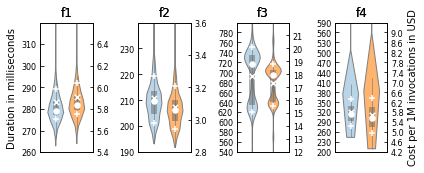

In [34]:
df_f1 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f1"]
df_f2 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f2"]
df_f3 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f3"]
df_f4 = AppMdl_lambda_logs.loc[AppMdl_lambda_logs.Function == "f4"]
sampleNum = min(len(df_f1), len(df_f2), len(df_f3), len(df_f4))
dur_f1 = np.asarray(df_f1[:sampleNum].Duration.values).reshape(sampleNum, 1)
dur_f2 = np.asarray(df_f2[:sampleNum].Duration.values).reshape(sampleNum, 1)
dur_f3 = np.asarray(df_f3[:sampleNum].Duration.values).reshape(sampleNum, 1)
dur_f4 = np.asarray(df_f4[:sampleNum].Duration.values).reshape(sampleNum, 1)
# plot:
fig, (ax_f1, ax_f2, ax_f3, ax_f4) = plt.subplots(nrows=1, ncols=4, figsize=(6, 2.4))

# plot f1
vp1 = ax_f1.violinplot(f1_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f1.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(260, 320), yticks=np.arange(260, 320, 10),
       title="f1")
ax_f1_cost = ax_f1.twinx()
vp1_twin = ax_f1_cost.violinplot(
        f1_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f1_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(5.4, 6.6), yticks=np.arange(5.4, 6.6, 0.2),
       title="f1")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f1_duration, [10, 25, 50, 75, 90])
mean = np.mean(f1_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f1_duration), quartile25, quartile75)
ax_f1.scatter([1.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f1.scatter([1.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f1.scatter([1.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f1.scatter([1.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f1.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f1.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f1_cost, [10, 25, 50, 75, 90])
mean = np.mean(f1_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f1_cost), quartile25, quartile75)
ax_f1_cost.scatter([3.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f1_cost.scatter([3.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f1_cost.scatter([3.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f1_cost.scatter([3.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f1_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f1_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f1.tick_params(axis='both', which='major', labelsize=8)
ax_f1_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f1.set_xticklabels([])
ax_f1_cost.set_xticklabels([])
ax_f1.tick_params(direction='in', bottom=False)
ax_f1_cost.tick_params(direction='in', bottom=False)



# plot f2
vp1 = ax_f2.violinplot(f2_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f2.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(190, 240), yticks=np.arange(190, 240, 10),
       title="f2")
ax_f2_cost = ax_f2.twinx()
vp1_twin = ax_f2_cost.violinplot(
        f2_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f2_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(2.8, 3.6), yticks=np.arange(2.8, 3.6, 0.2),
       title="f2")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f2_duration, [10, 25, 50, 75, 90])
mean = np.mean(f2_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f2_duration), quartile25, quartile75)
ax_f2.scatter([1.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f2.scatter([1.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f2.scatter([1.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f2.scatter([1.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f2.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f2.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f2_cost, [10, 25, 50, 75, 90])
mean = np.mean(f2_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f2_cost), quartile25, quartile75)
ax_f2_cost.scatter([3.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f2_cost.scatter([3.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f2_cost.scatter([3.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f2_cost.scatter([3.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f2_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f2_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f2.tick_params(axis='both', which='major', labelsize=8)
ax_f2_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f2.set_xticklabels([])
ax_f2_cost.set_xticklabels([])
ax_f2.tick_params(direction='in', bottom=False)
ax_f2_cost.tick_params(direction='in', bottom=False)


# plot f3
vp1 = ax_f3.violinplot(f3_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f3.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(540, 800), yticks=np.arange(540, 800, 20),
       title="f3")
ax_f3_cost = ax_f3.twinx()
vp1_twin = ax_f3_cost.violinplot(
        f3_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f3_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(12, 22), yticks=np.arange(12, 22, 1),
       title="f3")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f3_duration, [10, 25, 50, 75, 90])
mean = np.mean(f3_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f3_duration), quartile25, quartile75)
ax_f3.scatter([1.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f3.scatter([1.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f3.scatter([1.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f3.scatter([1.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f3.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f3.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f3_cost, [10, 25, 50, 75, 90])
mean = np.mean(f3_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f3_cost), quartile25, quartile75)
ax_f3_cost.scatter([3.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f3_cost.scatter([3.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f3_cost.scatter([3.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f3_cost.scatter([3.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f3_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f3_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f3.tick_params(axis='both', which='major', labelsize=8)
ax_f3_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f3.set_xticklabels([])
ax_f3_cost.set_xticklabels([])
ax_f3.tick_params(direction='in', bottom=False)
ax_f3_cost.tick_params(direction='in', bottom=False)

# plot f4
vp1 = ax_f4.violinplot(f4_duration, [1.5], widths=1.5,
                   showmeans=False, showmedians=False, showextrema=False)
# styling:
ax_f4.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(240, 550), yticks=np.arange(200, 600, 30),
       title="f4")
ax_f4_cost = ax_f4.twinx()
vp1_twin = ax_f4_cost.violinplot(
        f4_cost, [3.5], showmeans=False, showmedians=False,
        showextrema=False,  widths=1.5)
ax_f4_cost.set(xlim=(0, 5), xticks=np.arange(0, 5),
       ylim=(4.2, 9.4), yticks=np.arange(4.2, 9.4, 0.4),
       title="f4")

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f4_duration, [10, 25, 50, 75, 90])
mean = np.mean(f4_duration)
whiskers_min, whiskers_max = adjacent_values(np.sort(f4_duration), quartile25, quartile75)
ax_f4.scatter([1.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f4.scatter([1.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f4.scatter([1.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f4.scatter([1.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f4.vlines([1.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f4.vlines([1.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

percentile10, quartile25, medians, quartile75, percentile90 = np.percentile(f4_cost, [10, 25, 50, 75, 90])
mean = np.mean(f4_cost)
whiskers_min, whiskers_max = adjacent_values(np.sort(f4_cost), quartile25, quartile75)
ax_f4_cost.scatter([3.5], medians, marker='o', color='white', s=30, zorder=3)
ax_f4_cost.scatter([3.5], mean, marker='x', color='white', s=30, zorder=3)
ax_f4_cost.scatter([3.5], percentile10, marker='+', color='white', s=30, zorder=3)
ax_f4_cost.scatter([3.5], percentile90, marker='+', color='white', s=30, zorder=3)
ax_f4_cost.vlines([3.5], quartile25, quartile75, color='#666666', linestyle='-', lw=6, alpha=0.5)
ax_f4_cost.vlines([3.5], whiskers_min, whiskers_max, color='#666666', linestyle='-', lw=1, alpha=0.5)

for pc in vp1["bodies"]:
    pc.set_facecolor('#BBD5E8')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
for pc in vp1_twin['bodies']:
    pc.set_facecolor('#FFB570')
    pc.set_edgecolor('grey')
    pc.set_alpha(1)
ax_f4.tick_params(axis='both', which='major', labelsize=8)
ax_f4_cost.tick_params(axis='both', which='major', labelsize=8)
ax_f4.set_xticklabels([])
ax_f4_cost.set_xticklabels([])
ax_f4.tick_params(direction='in', bottom=False)
ax_f4_cost.tick_params(direction='in', bottom=False)


ax_f1.set_ylabel('Duration in milliseconds')
ax_f4_cost.set_ylabel('Cost per 1M invocations in USD')


plt.subplots_adjust(bottom=0.15, wspace=0.3)
plt.tight_layout()
plt.show()
fig.savefig("4_function_pp.pdf")